<a href="https://colab.research.google.com/github/Yyzhang2000/learning-generative-models/blob/main/vae/01_vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

from tqdm.autonotebook import trange

<ipython-input-1-bc479d04897e>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [ ]:
DATA_PATH = "./data"
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(DATA_PATH, transform=transform, download=True)
test_dataset  = MNIST(DATA_PATH, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.28MB/s]


# Autoencoder Model

In [ ]:
class Encoder(nn.Module):
    def __init__(
            self,
            in_dim = 28 * 28,
            hidden_dim = 512,
            latent_dim = 256
    ):
        super().__init__()

        self.ln1 = nn.Linear(in_dim, hidden_dim, bias = False)
        self.ln2 = nn.Linear(hidden_dim, hidden_dim, bias = False)

        self.mean = nn.Linear(hidden_dim, latent_dim, bias = False)
        self.log_var = nn.Linear(hidden_dim, latent_dim)

        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        hidden = self.act(self.ln2(self.act(self.ln1(x))))

        mean = self.mean(hidden)
        log_var = self.log_var(hidden)

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_dim=28 * 28, hidden_dim=512, latent_dim = 256):
        super().__init__()

        self.ln1 = nn.Linear(latent_dim, hidden_dim, bias = False)
        self.ln2 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.output = nn.Linear(hidden_dim, out_dim, bias = False)

        self.act = nn.LeakyReLU(0.2)

    def forward(self, z):
        hidden = self.act(self.ln2(self.act(self.ln1(z))))

        x_hat = F.sigmoid(self.output(hidden))

        return x_hat

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self, x):
        mean, log_var  = self.encoder(x)
        return mean, log_var

    def decode(self, z):
        return self.decoder(z)

    def reparameterization(self, mean, var):
        eps = torch.rand_like(var).to(mean.device)
        z = mean + var * eps
        return z

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    construction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_Div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return construction_loss + KL_Div

In [ ]:
model.train()
losses = []
for epoch in trange(50):
    for x, _ in train_loader:
        x = x.flatten(1).to(device)

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses);

  0%|          | 0/50 [00:00<?, ?it/s]

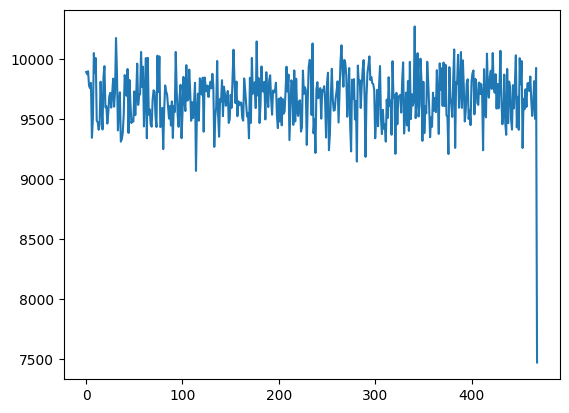

# Sampling from the Generative Models

In [ ]:
def random_sample(model):
    model.eval()
    model.to(device)
    with torch.no_grad():
        z = torch.randn((1, 256)).to(device)
        x_hat = model.decode(z)

    x_hat = x_hat.detach().cpu()
    x_hat = x_hat.squeeze(0)
    x_hat = x_hat.reshape(28, 28)
    return x_hat

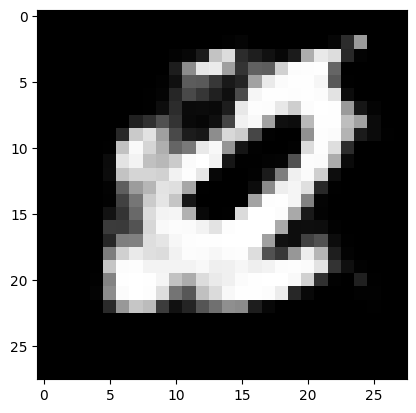

In [ ]:
x_hat = random_sample(model)
plt.imshow(x_hat,  cmap='gray');

In [ ]:
number_to_z = {}

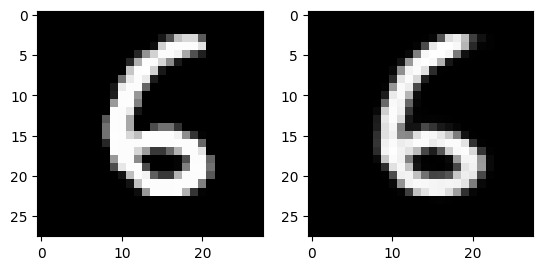

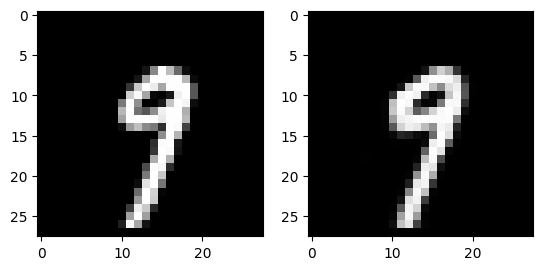

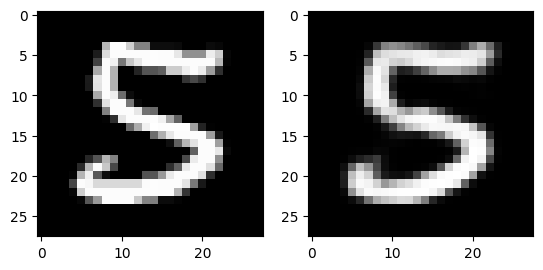

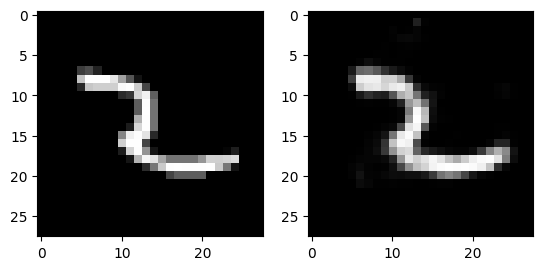

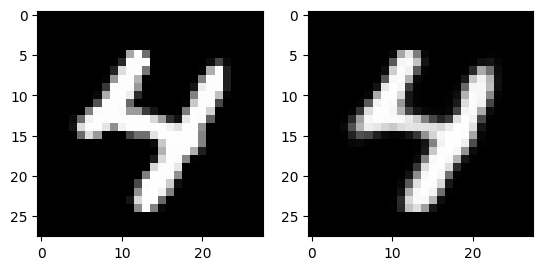

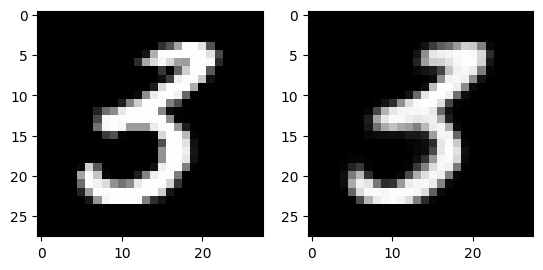

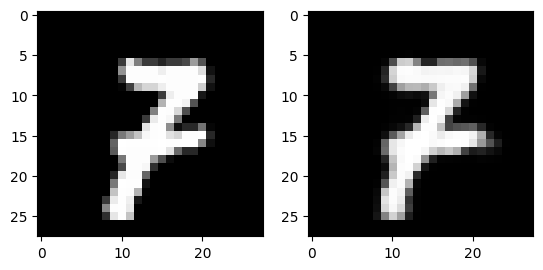

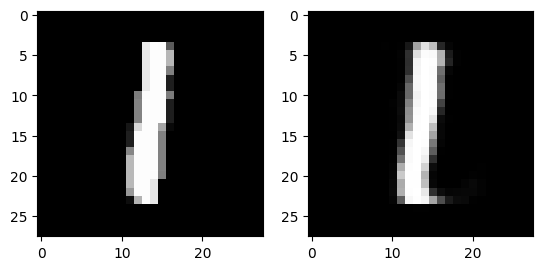

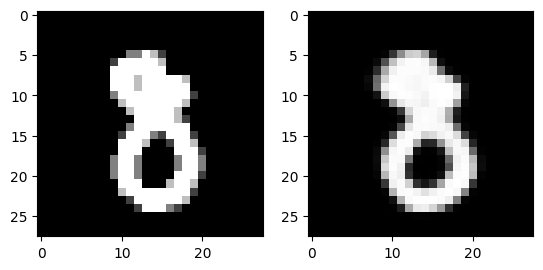

In [ ]:
model.eval()
for x, y in test_loader:
    indice = random.randint(0, len(x) - 1)
    a = x[indice]
    t = y[indice].item()
    if t in number_to_z:

        continue
    a = a.flatten(1).cuda()
    recon, mu, std = model(a)
    number_to_z[t] = {
        'mu' : mu.detach().cpu(),
        'std': std.detach().cpu(),
    }
    if len(number_to_z) == 10:
        break
    b = recon[0].reshape(28,28)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(a.reshape(28, 28).detach().cpu().numpy(), cmap='gray')
    axarr[1].imshow(b.detach().cpu().numpy(), cmap='gray')

In [ ]:
def sample(model, mean, var):
    model.eval()
    model = model.to(mean.device)
    with torch.no_grad():
        eps = torch.rand_like(var).to(mean.device)
        z = mean + var * eps
        x_hat = model.decode(z)

    x_hat = x_hat.detach().cpu()
    x_hat = x_hat.squeeze(0)
    x_hat = x_hat.reshape(28, 28)
    return x_hat

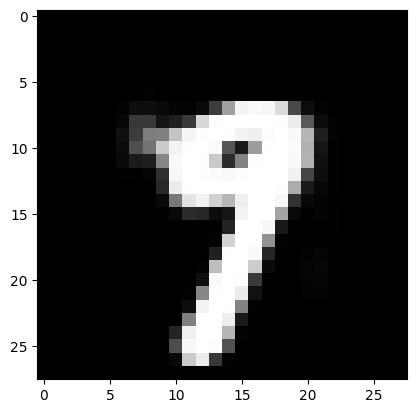

In [ ]:
x_hat = sample(model, *number_to_z[9].values())
plt.imshow(x_hat,  cmap='gray');

In [ ]:
|